# 🚜 Predicting the Sale Price of Bulldozers using Machine Learning 🚜

This is project, which predicts the sale price of bulldozeres using machine learning.

## 1. Problem Definition

> How well can I predict the feature sale price of a bulldozer, given its characteristics and previous example of how much similar bulldozers have been sold for?

## 2. Data

The data is downloaded from the Kaggle Bluebook for Bulldozers competition: https://www.kaggle.com/competitions/bluebook-for-bulldozers/data

There are 3 main datasets

* Train.csv is the training set, which contains data through the end of 2011.
* Valid.csv is the validation set, which contains data from January 1, 2012 - April 30, 2012 You make predictions on this set throughout the majority of the competition. Your score on this set is used to create the public leaderboard.
* Test.csv is the test set, which won't be released until the last week of the competition. It contains data from May 1, 2012 - November 2012. Your score on the test set determines your final rank for the competition.

## 3. Evaluation

The evaluation metric for this competition is the RMSLE (root mean squared log error) between the actual and predicted auction prices.

For more on the evaluation of this project check: https://www.kaggle.com/competitions/bluebook-for-bulldozers/overview

**Note:** The goal for most regression evaluation metrics is to minimize the error. For example, our goal for this project will be to build a machine learning model which minimises RMSLE.

## 4. Features

Kaggle provides a data dictionary detailing all of the features of the dataset. You can view this data dictionary on Google Sheets:
https://docs.google.com/spreadsheets/d/1O84oaT8Qh_jciS56_cGPavWRlIQsT0If/edit?usp=sharing&ouid=113270940209768386185&rtpof=true&sd=true

### Preparing Tools

In [1]:
# Regular EDA (Exploratory Data Analysis)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# Model from Scikit-Learn
from sklearn.ensemble import RandomForestRegressor

# Model evaluation
from sklearn.metrics import mean_squared_log_error, mean_absolute_error, r2_score
from sklearn.model_selection import RandomizedSearchCV

### Define Functions

In [42]:
# Create evaluation function (the competition uses RMSLE)
def rmsle(y_test, y_preds):
    '''
    Calculates root mean squared log error between predictions and true labels.
    '''
    return np.sqrt(mean_squared_log_error(y_test, y_preds))

# Create function to evaluate model on few different levels
def show_scores(model):
    train_preds = model.predict(X_train)
    valid_preds = model.predict(X_valid)
    scores = {
        'Training MAE': mean_absolute_error(y_train, train_preds),
        'Valid MAE': mean_absolute_error(y_valid, valid_preds),
        'Training RMSLE': rmsle(y_train, train_preds),
        'Valid RMSLE': rmsle(y_valid, valid_preds),
        'Training R^2': r2_score(y_train, train_preds),
        'Valid R^2': r2_score(y_valid, valid_preds)
    }
    return scores

def preprocess_data(df):
    # Add datetime parameters for saledate
    df["saleYear"] = df.saledate.dt.year
    df["saleMonth"] = df.saledate.dt.month
    df["saleDay"] = df.saledate.dt.day
    df["saleDayOfWeek"] = df.saledate.dt.dayofweek
    df["saleDayOfYear"] = df.saledate.dt.dayofyear
    # Drop original saledate
    df.drop("saledate", axis=1, inplace=True)
    # Fill numeric rows with median
    for label, content in df.items():
        if pd.api.types.is_numeric_dtype(content):
            if pd.isnull(content).sum():
                df[label+'_is_missing'] = pd.isnull(content)
                df[label] = content.fillna(content.median())
        # Turn categorical variables into numbers
        if not pd.api.types.is_numeric_dtype(content):
            df[label+'_is_missing'] = pd.isnull(content)
            # Add +1
            df[label] = pd.Categorical(content).codes + 1
    return df

def plot_features(columns, importances, n = 20):
    df = (pd.DataFrame({
        'features': columns,
        'feature_importance': importances
    }).sort_values('feature_importance', ascending = False).reset_index(drop = True))
    sns.barplot(x='feature_importance',
                y='features',
                data=df[:n],
                orient='h')

### Import Data with Parsing Dates

In [3]:
# Import training and validation sets
df = pd.read_csv('data/bluebook-for-bulldozers/TrainAndValid.csv',
                 low_memory = False,
                 parse_dates = ['saledate'])

In [4]:
# See first 5 rows
df.head()

,SalesID,SalePrice,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,saledate,...,Undercarriage_Pad_Width,Stick_Length,Thumb,Pattern_Changer,Grouser_Type,Backhoe_Mounting,Blade_Type,Travel_Controls,Differential_Type,Steering_Controls
0,1139246,66000.0,999089,3157,121,3.0,2004,68.0,Low,2006-11-16,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Standard,Conventional
1,1139248,57000.0,117657,77,121,3.0,1996,4640.0,Low,2004-03-26,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Standard,Conventional
2,1139249,10000.0,434808,7009,121,3.0,2001,2838.0,High,2004-02-26,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1139251,38500.0,1026470,332,121,3.0,2001,3486.0,High,2011-05-19,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1139253,11000.0,1057373,17311,121,3.0,2007,722.0,Medium,2009-07-23,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
# See basics info of DataFrame
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 412698 entries, 0 to 412697
Data columns (total 53 columns):
 #   Column                    Non-Null Count   Dtype         
---  ------                    --------------   -----         
 0   SalesID                   412698 non-null  int64         
 1   SalePrice                 412698 non-null  float64       
 2   MachineID                 412698 non-null  int64         
 3   ModelID                   412698 non-null  int64         
 4   datasource                412698 non-null  int64         
 5   auctioneerID              392562 non-null  float64       
 6   YearMade                  412698 non-null  int64         
 7   MachineHoursCurrentMeter  147504 non-null  float64       
 8   UsageBand                 73670 non-null   object        
 9   saledate                  412698 non-null  datetime64[ns]
 10  fiModelDesc               412698 non-null  object        
 11  fiBaseModel               412698 non-null  object        
 12  fi

In [6]:
# Missing values
df.isna().sum()

SalesID                          0
SalePrice                        0
MachineID                        0
ModelID                          0
datasource                       0
auctioneerID                 20136
YearMade                         0
MachineHoursCurrentMeter    265194
UsageBand                   339028
saledate                         0
fiModelDesc                      0
fiBaseModel                      0
fiSecondaryDesc             140727
fiModelSeries               354031
fiModelDescriptor           337882
ProductSize                 216605
fiProductClassDesc               0
state                            0
ProductGroup                     0
ProductGroupDesc                 0
Drive_System                305611
Enclosure                      334
Forks                       214983
Pad_Type                    331602
Ride_Control                259970
Stick                       331602
Transmission                224691
Turbocharged                331602
Blade_Extension     

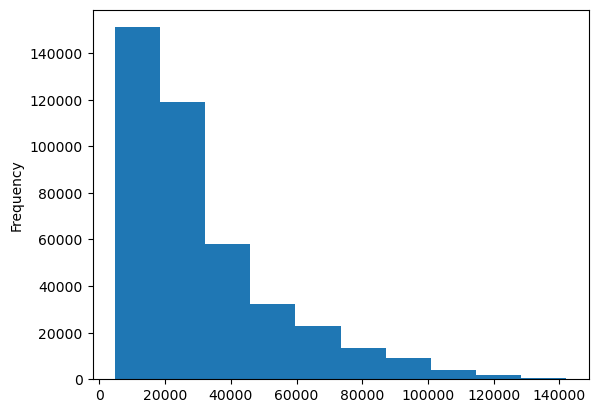

In [7]:
# Distribution of sale price
df.SalePrice.plot.hist();

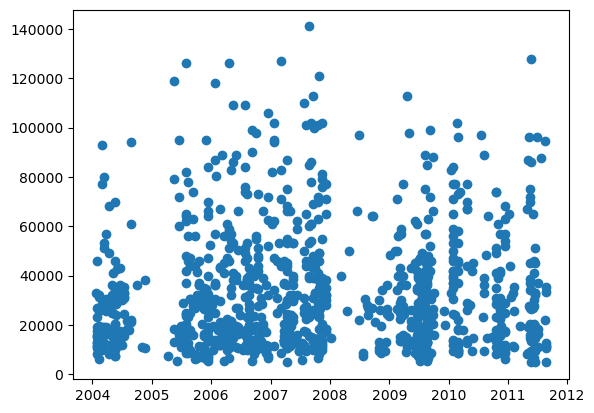

In [8]:
# Visualize sale data and sale price
fig, ax = plt.subplots()
ax.scatter(df['saledate'][:1000], df['SalePrice'][:1000]);

In [9]:
# See all columns
df.head().T

,0,1,2,3,4
SalesID,1139246,1139248,1139249,1139251,1139253
SalePrice,66000.0,57000.0,10000.0,38500.0,11000.0
MachineID,999089,117657,434808,1026470,1057373
ModelID,3157,77,7009,332,17311
datasource,121,121,121,121,121
auctioneerID,3.0,3.0,3.0,3.0,3.0
YearMade,2004,1996,2001,2001,2007
MachineHoursCurrentMeter,68.0,4640.0,2838.0,3486.0,722.0
UsageBand,Low,Low,High,High,Medium
saledate,2006-11-16 00:00:00,2004-03-26 00:00:00,2004-02-26 00:00:00,2011-05-19 00:00:00,2009-07-23 00:00:00


### Sort DateFrame by saledate

In [10]:
# Sort in date order
df.sort_values(by = ['saledate'],
               inplace = True,
               ascending = True)

In [11]:
df.head()

,SalesID,SalePrice,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,saledate,...,Undercarriage_Pad_Width,Stick_Length,Thumb,Pattern_Changer,Grouser_Type,Backhoe_Mounting,Blade_Type,Travel_Controls,Differential_Type,Steering_Controls
205615,1646770,9500.0,1126363,8434,132,18.0,1974,NaN,NaN,1989-01-17,...,NaN,NaN,NaN,NaN,NaN,None or Unspecified,Straight,None or Unspecified,NaN,NaN
274835,1821514,14000.0,1194089,10150,132,99.0,1980,NaN,NaN,1989-01-31,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Standard,Conventional
141296,1505138,50000.0,1473654,4139,132,99.0,1978,NaN,NaN,1989-01-31,...,NaN,NaN,NaN,NaN,NaN,None or Unspecified,Straight,None or Unspecified,NaN,NaN
212552,1671174,16000.0,1327630,8591,132,99.0,1980,NaN,NaN,1989-01-31,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Standard,Conventional
62755,1329056,22000.0,1336053,4089,132,99.0,1984,NaN,NaN,1989-01-31,...,NaN,NaN,NaN,NaN,NaN,None or Unspecified,PAT,Lever,NaN,NaN


### Make a copy of the original DataFrame

In [12]:
# Make a copy
df_tmp = df.copy()

### Preprocessing

In [13]:
# Check the values of different columns
df_tmp.state.value_counts()

state
Florida           67320
Texas             53110
California        29761
Washington        16222
Georgia           14633
Maryland          13322
Mississippi       13240
Ohio              12369
Illinois          11540
Colorado          11529
New Jersey        11156
North Carolina    10636
Tennessee         10298
Alabama           10292
Pennsylvania      10234
South Carolina     9951
Arizona            9364
New York           8639
Connecticut        8276
Minnesota          7885
Missouri           7178
Nevada             6932
Louisiana          6627
Kentucky           5351
Maine              5096
Indiana            4124
Arkansas           3933
New Mexico         3631
Utah               3046
Unspecified        2801
Wisconsin          2745
New Hampshire      2738
Virginia           2353
Idaho              2025
Oregon             1911
Michigan           1831
Wyoming            1672
Montana            1336
Iowa               1336
Oklahoma           1326
Nebraska            866
West Virgi

In [14]:
# Use preprocess function
df_tmp = preprocess_data(df_tmp)

In [15]:
# Check my DataFrame
df_tmp.info()

<class 'pandas.core.frame.DataFrame'>
Index: 412698 entries, 205615 to 409203
Columns: 103 entries, SalesID to Steering_Controls_is_missing
dtypes: bool(46), float64(3), int16(4), int32(5), int64(5), int8(40)
memory usage: 73.2 MB


In [16]:
df_tmp.isna().sum()

SalesID                         0
SalePrice                       0
MachineID                       0
ModelID                         0
datasource                      0
                               ..
Backhoe_Mounting_is_missing     0
Blade_Type_is_missing           0
Travel_Controls_is_missing      0
Differential_Type_is_missing    0
Steering_Controls_is_missing    0
Length: 103, dtype: int64

In [17]:
df_tmp.head().T

,205615,274835,141296,212552,62755
SalesID,1646770,1821514,1505138,1671174,1329056
SalePrice,9500.0,14000.0,50000.0,16000.0,22000.0
MachineID,1126363,1194089,1473654,1327630,1336053
ModelID,8434,10150,4139,8591,4089
datasource,132,132,132,132,132
...,...,...,...,...,...
Backhoe_Mounting_is_missing,False,True,False,True,False
Blade_Type_is_missing,False,True,False,True,False
Travel_Controls_is_missing,False,True,False,True,False
Differential_Type_is_missing,True,False,True,False,True


## 5. Modelling

In [18]:
# Split data into train and validation sets
df_train = df_tmp[df_tmp.saleYear != 2012]
df_val = df_tmp[df_tmp.saleYear == 2012]

len(df_train), len(df_val)

(401125, 11573)

In [19]:
# Split date into X and y
X_train, y_train = df_train.drop('SalePrice', axis=1), df_train.SalePrice
X_valid, y_valid = df_val.drop('SalePrice', axis=1), df_val.SalePrice

In [20]:
%%time
# Create a model
model = RandomForestRegressor(n_jobs = -1,
                              random_state = 24,
                              max_samples = 10000)
# Fit the model
model.fit(X_train, y_train)

CPU times: user 54.8 s, sys: 987 ms, total: 55.8 s
Wall time: 4.25 s


RandomForestRegressor(max_samples=10000, n_jobs=-1, random_state=24)

In [21]:
# See scores
show_scores(model)

{'Training MAE': 5565.238634315988,
 'Valid MAE': 7138.68046919554,
 'Training RMSLE': 0.2574693260077623,
 'Valid RMSLE': 0.29200220033056695,
 'Training R^2': 0.8601419825420646,
 'Valid R^2': 0.8345276366602258}

### Hyperparameters tuning with `RandomizedSearchCV`

In [22]:
%%time
# Different hyperparameters dictionary
rf_grid = {
    'n_estimators': np.arange(10, 100, 10),
    'max_depth': [None, 3, 5, 10],
    'min_samples_split': np.arange(2, 20, 2),
    'min_samples_leaf': np.arange(1, 20, 2),
    'max_features': [0.5, 1, 'sqrt', 'auto'],
    'max_samples': [10000]
}

# Instantiate RandomizedSearchCV model
rs_model = RandomizedSearchCV(RandomForestRegressor(n_jobs = -1,
                                                    random_state = 24),
                              param_distributions = rf_grid,
                              n_iter = 100,
                              cv = 5, 
                              verbose = True)

# Fit the RandomizedSearchCV model
rs_model.fit(X_train, y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


/Users/kamil/bulldoxer-price-prediction-project/env/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
140 fits failed out of a total of 500.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
140 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/kamil/bulldoxer-price-prediction-project/env/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/kamil/bulldoxer-price-prediction-project/env/lib/python3.10/site-packages/sklearn/base.py", line 1144, in wrapper
    estimator._validate_params()
  File "/Users/kamil/bulldoxer-price-prediction-project/env/lib/pytho

CPU times: user 5min 17s, sys: 1min 32s, total: 6min 49s
Wall time: 10min 3s


RandomizedSearchCV(cv=5,
                   estimator=RandomForestRegressor(n_jobs=-1, random_state=24),
                   n_iter=100,
                   param_distributions={'max_depth': [None, 3, 5, 10],
                                        'max_features': [0.5, 1, 'sqrt',
                                                         'auto'],
                                        'max_samples': [10000],
                                        'min_samples_leaf': array([ 1,  3,  5,  7,  9, 11, 13, 15, 17, 19]),
                                        'min_samples_split': array([ 2,  4,  6,  8, 10, 12, 14, 16, 18]),
                                        'n_estimators': array([10, 20, 30, 40, 50, 60, 70, 80, 90])},
                   verbose=True)

In [23]:
# Find best hyperparameters
rs_model.best_params_

{'n_estimators': 90,
 'min_samples_split': 14,
 'min_samples_leaf': 5,
 'max_samples': 10000,
 'max_features': 0.5,
 'max_depth': None}

In [24]:
# Evaluate the RandomizedSearchCV model
show_scores(rs_model)

{'Training MAE': 6100.439441029747,
 'Valid MAE': 7412.2411530179315,
 'Training RMSLE': 0.2773547641919714,
 'Valid RMSLE': 0.30119732416356665,
 'Training R^2': 0.8342208321700375,
 'Valid R^2': 0.8204304132549514}

In [25]:
# Instantiate mode with best hyperparameters
model = RandomForestRegressor(n_jobs = -1,
                              random_state = 24,
                              n_estimators = 90,
                              min_samples_split = 14,
                              min_samples_leaf = 5,
                              max_samples = None,
                              max_features = 0.5,
                              max_depth = None)

# Fit the model
model.fit(X_train, y_train)

RandomForestRegressor(max_features=0.5, min_samples_leaf=5,
                      min_samples_split=14, n_estimators=90, n_jobs=-1,
                      random_state=24)

## 6. Experimantions

### Make predictions on test data

In [26]:
df_test = pd.read_csv('data/bluebook-for-bulldozers/Test.csv',
                      low_memory = False,
                      parse_dates = ['saledate'])
df_test.head()

,SalesID,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,saledate,fiModelDesc,...,Undercarriage_Pad_Width,Stick_Length,Thumb,Pattern_Changer,Grouser_Type,Backhoe_Mounting,Blade_Type,Travel_Controls,Differential_Type,Steering_Controls
0,1227829,1006309,3168,121,3,1999,3688.0,Low,2012-05-03,580G,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1227844,1022817,7271,121,3,1000,28555.0,High,2012-05-10,936,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Standard,Conventional
2,1227847,1031560,22805,121,3,2004,6038.0,Medium,2012-05-10,EC210BLC,...,None or Unspecified,"9' 6""",Manual,None or Unspecified,Double,NaN,NaN,NaN,NaN,NaN
3,1227848,56204,1269,121,3,2006,8940.0,High,2012-05-10,330CL,...,None or Unspecified,None or Unspecified,Manual,Yes,Triple,NaN,NaN,NaN,NaN,NaN
4,1227863,1053887,22312,121,3,2005,2286.0,Low,2012-05-10,650K,...,NaN,NaN,NaN,NaN,NaN,None or Unspecified,PAT,None or Unspecified,NaN,NaN


In [27]:
# Let's preprocess my test DataFrame
df_test = preprocess_data(df_test)
df_test.head()

,SalesID,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,fiModelDesc,fiBaseModel,...,Undercarriage_Pad_Width_is_missing,Stick_Length_is_missing,Thumb_is_missing,Pattern_Changer_is_missing,Grouser_Type_is_missing,Backhoe_Mounting_is_missing,Blade_Type_is_missing,Travel_Controls_is_missing,Differential_Type_is_missing,Steering_Controls_is_missing
0,1227829,1006309,3168,121,3,1999,3688.0,2,499,180,...,True,True,True,True,True,True,True,True,True,True
1,1227844,1022817,7271,121,3,1000,28555.0,1,831,292,...,True,True,True,True,True,True,True,True,False,False
2,1227847,1031560,22805,121,3,2004,6038.0,3,1177,404,...,False,False,False,False,False,True,True,True,True,True
3,1227848,56204,1269,121,3,2006,8940.0,1,287,113,...,False,False,False,False,False,True,True,True,True,True
4,1227863,1053887,22312,121,3,2005,2286.0,2,566,196,...,True,True,True,True,True,False,False,False,True,True


In [28]:
# Check X train DataFrame
X_train.head()

,SalesID,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,fiModelDesc,fiBaseModel,...,Undercarriage_Pad_Width_is_missing,Stick_Length_is_missing,Thumb_is_missing,Pattern_Changer_is_missing,Grouser_Type_is_missing,Backhoe_Mounting_is_missing,Blade_Type_is_missing,Travel_Controls_is_missing,Differential_Type_is_missing,Steering_Controls_is_missing
205615,1646770,1126363,8434,132,18.0,1974,0.0,0,4593,1744,...,True,True,True,True,True,False,False,False,True,True
274835,1821514,1194089,10150,132,99.0,1980,0.0,0,1820,559,...,True,True,True,True,True,True,True,True,False,False
141296,1505138,1473654,4139,132,99.0,1978,0.0,0,2348,713,...,True,True,True,True,True,False,False,False,True,True
212552,1671174,1327630,8591,132,99.0,1980,0.0,0,1819,558,...,True,True,True,True,True,True,True,True,False,False
62755,1329056,1336053,4089,132,99.0,1984,0.0,0,2119,683,...,True,True,True,True,True,False,False,False,True,True


In [29]:
# We can find how the columns differ using sets
set(X_train.columns) - set(df_test.columns)

{'auctioneerID_is_missing'}

In [30]:
# Adjust df_test
df_test['auctioneerID_is_missing'] = False

In [31]:
df_test.head()

,SalesID,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,fiModelDesc,fiBaseModel,...,Stick_Length_is_missing,Thumb_is_missing,Pattern_Changer_is_missing,Grouser_Type_is_missing,Backhoe_Mounting_is_missing,Blade_Type_is_missing,Travel_Controls_is_missing,Differential_Type_is_missing,Steering_Controls_is_missing,auctioneerID_is_missing
0,1227829,1006309,3168,121,3,1999,3688.0,2,499,180,...,True,True,True,True,True,True,True,True,True,False
1,1227844,1022817,7271,121,3,1000,28555.0,1,831,292,...,True,True,True,True,True,True,True,False,False,False
2,1227847,1031560,22805,121,3,2004,6038.0,3,1177,404,...,False,False,False,False,True,True,True,True,True,False
3,1227848,56204,1269,121,3,2006,8940.0,1,287,113,...,False,False,False,False,True,True,True,True,True,False
4,1227863,1053887,22312,121,3,2005,2286.0,2,566,196,...,True,True,True,True,False,False,False,True,True,False


In [32]:
# Match column order from X_train to df_test
df_test = df_test[X_train.columns]

In [34]:
# Make predictions on the test dataset using the best model
test_preds = model.predict(df_test)

In [35]:
# Format predictions into the same format as Kaggle
df_preds = pd.DataFrame()
df_preds['SalesID'] = df_test['SalesID']
df_preds['SalesPrice'] = test_preds
df_preds.head()

,SalesID,SalesPrice
0,1227829,17730.486318
1,1227844,17054.800468
2,1227847,51318.884320
3,1227848,66459.153513
4,1227863,55024.738016


### Feature Importance

In [36]:
# Find feature importance of the model
model.feature_importances_

array([3.25272128e-02, 1.88330919e-02, 4.50004975e-02, 1.93169160e-03,
       2.71229843e-03, 2.03113798e-01, 2.62489060e-03, 8.57508467e-04,
       4.31870618e-02, 4.52241140e-02, 6.36578419e-02, 4.77140057e-03,
       2.00636859e-02, 1.47151685e-01, 4.66197470e-02, 4.99566808e-03,
       2.42415113e-03, 3.22389361e-03, 3.17718493e-03, 7.01556702e-02,
       5.45326936e-04, 2.54952399e-04, 7.05638363e-04, 1.85958410e-04,
       9.84409258e-04, 1.37980280e-05, 1.50036547e-03, 6.56196189e-03,
       2.32094026e-03, 5.91174408e-04, 3.48188165e-03, 3.92388620e-03,
       4.01032176e-03, 1.75528152e-03, 2.05006269e-03, 1.07311234e-02,
       6.95682539e-04, 1.11299745e-02, 3.10486302e-03, 2.26422579e-03,
       9.47585379e-04, 8.51472866e-04, 2.38159986e-03, 4.90610976e-04,
       4.35019179e-04, 2.36530264e-04, 5.20551956e-04, 1.81662733e-03,
       9.71992217e-04, 2.44646275e-04, 2.46162748e-04, 7.37851784e-02,
       3.58533034e-03, 4.72486412e-03, 2.37785482e-03, 8.66205232e-03,
      

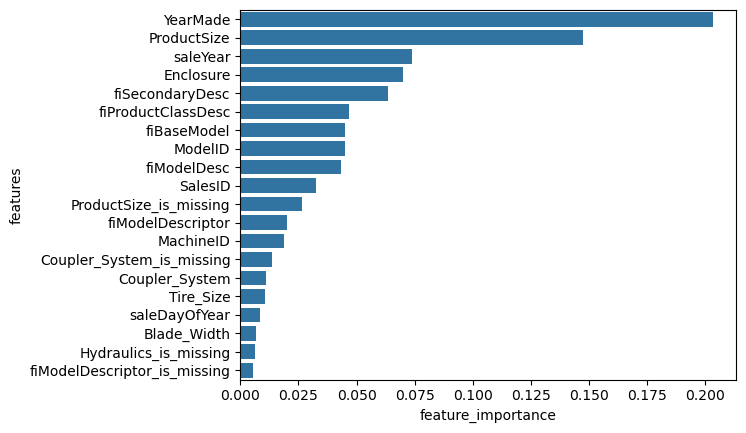

In [43]:
# Plotting feature importance
plot_features(X_train.columns, model.feature_importances_)